# Data Import and pre processing

In [2]:
!pip install q tensorflow==2.1
!pip install q keras==2.3.1
!pip install segmentation_models
import segmentation_models as sm

!pip install h5py==2.10.0

# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
# !pip install -U albumentations==0.3.0 --user
!pip install -U albumentations==0.2.3 --user 

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [32]:
import os
patchsize = 256

# Training data
x_train_dir = '/content/drive/MyDrive/Segmentation DS/384 DS Covid/Traintest/train/images'
y_train_dir = '/content/drive/MyDrive/Segmentation DS/384 DS Covid/Traintest/train/masks'

# Validation data
x_valid_dir = '/content/drive/MyDrive/Segmentation DS/384 DS Covid/Traintest/test/images'
y_valid_dir = '/content/drive/MyDrive/Segmentation DS/384 DS Covid/Traintest/test/masks'


x_test_dir = '/content/drive/MyDrive/Segmentation DS/384 DS Covid/Traintest/test/images'
y_test_dir = '/content/drive/MyDrive/Segmentation DS/384 DS Covid/Traintest/test/masks'

print("Training and validation and test samples: ", len(os.listdir(x_train_dir)), len(os.listdir(x_valid_dir)), len(os.listdir(x_test_dir)))

Training and validation and test samples:  500 20 20


In [33]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['target1' , 'background']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()



#####################################################
    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        # newer version of tf/keras want batch to be in tuple rather than list
        return tuple(batch)
#########################################################




    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

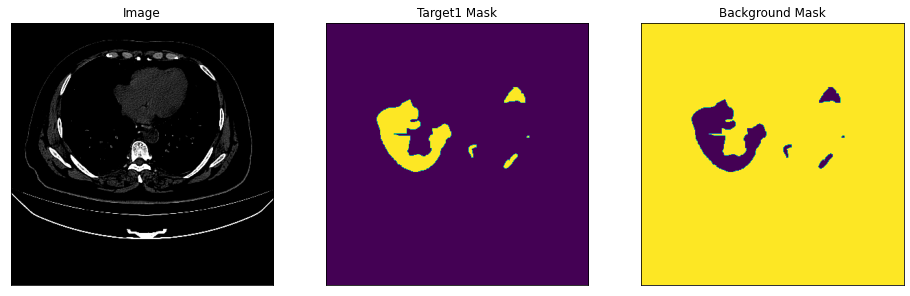

In [40]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['target1' , 'background'])

image, mask = dataset[53] # get some sample
visualize(
    image=image, 
    target1_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 0].squeeze(),
)

In [41]:
import albumentations as A

In [42]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        A.RandomCrop(height=256, width=256, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        # A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(256, 256)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        # A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

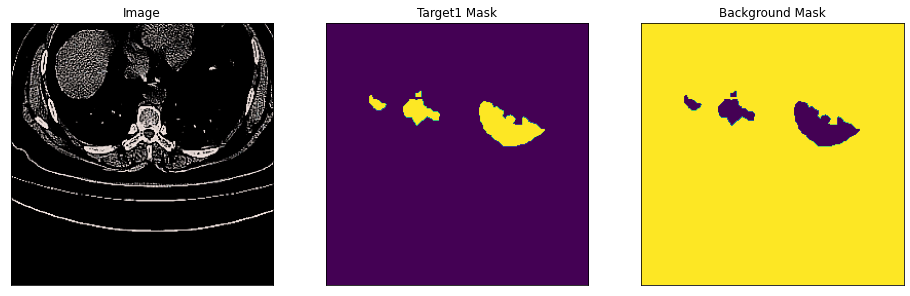

In [44]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['target1', 'background'], augmentation=get_training_augmentation())

image, mask = dataset[43] # get some sample
visualize(
    image=image, 
    # cars_mask=mask[..., 0].squeeze(),
    target1_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 0].squeeze(),
)

# FPN + EB3

In [45]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

In [46]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['target1']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [47]:
# define network parameters
n_classes = 1 
# f len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' 
# if n_classes == 1 else 'softmax'

#create model
model = sm.FPN(BACKBONE, classes=n_classes, activation=activation)



# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (256, 256, 3), activation=activation)
# I personally would chose (None, None, 3) for the input shape
#

44113920/44107200 [==============================] - 0s 0us/step


In [48]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [49]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('./fpn-EfficientNetB3.csv', separator=",", append=True)
]

In [50]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
62/62 [==============================] - 681s 11s/step - loss: 0.2353 - iou_score: 0.7858 - f1-score: 0.8647 - val_loss: 0.2242 - val_iou_score: 0.8537 - val_f1-score: 0.9204
Epoch 2/10
62/62 [==============================] - 85s 1s/step - loss: 0.1053 - iou_score: 0.9318 - f1-score: 0.9645 - val_loss: 0.1396 - val_iou_score: 0.8991 - val_f1-score: 0.9468
Epoch 3/10
62/62 [==============================] - 84s 1s/step - loss: 0.0898 - iou_score: 0.9405 - f1-score: 0.9692 - val_loss: 0.1246 - val_iou_score: 0.9211 - val_f1-score: 0.9588
Epoch 4/10
62/62 [==============================] - 85s 1s/step - loss: 0.0797 - iou_score: 0.9459 - f1-score: 0.9721 - val_loss: 0.1115 - val_iou_score: 0.9358 - val_f1-score: 0.9667
Epoch 5/10
62/62 [==============================] - 84s 1s/step - loss: 0.0736 - iou_score: 0.9513 - f1-score: 0.9749 - val_loss: 0.1481 - val_iou_score: 0.8994 - val_f1-score: 0.9469
Epoch 6/10
62/62 [==============================] - 85s 1s/step - loss: 0.0616

In [56]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.045974
mean iou_score: 0.96534
mean f1-score: 0.98231


In [57]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.12718
mean iou_score: 0.92133
mean f1-score: 0.95891


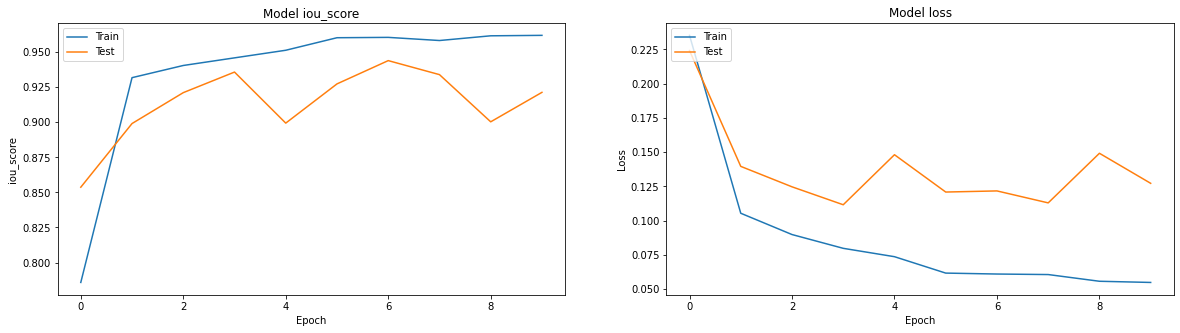

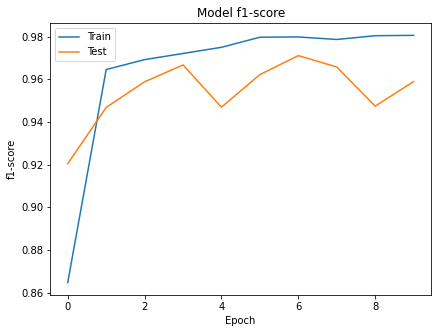

In [58]:
# Plot training & validation iou_score values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



# Plot training & validation f1_score values
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [59]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

In [ ]:
# load best weights
# model.load_weights('best_model.h5') 

In [60]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.12718
mean iou_score: 0.92133
mean f1-score: 0.95891


# FPN + vgg19

In [61]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

In [62]:
BACKBONE = 'vgg19'
BATCH_SIZE = 8
CLASSES = ['target1']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [63]:
# define network parameters
n_classes = 1 
# f len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' 
# if n_classes == 1 else 'softmax'

#create model
model = sm.FPN(BACKBONE, classes=n_classes, activation=activation)



# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (256, 256, 3), activation=activation)
# I personally would chose (None, None, 3) for the input shape
#

80142336/80134624 [==============================] - 4s 0us/step


In [64]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [65]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/fpn binary/best_modelvgg19.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/fpn binary/fpn-vgg19.csv', separator=",", append=True)
]

In [66]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
62/62 [==============================] - 81s 1s/step - loss: 0.2074 - iou_score: 0.8228 - f1-score: 0.8934 - val_loss: 0.3140 - val_iou_score: 0.7953 - val_f1-score: 0.8857
Epoch 2/10
62/62 [==============================] - 72s 1s/step - loss: 0.1081 - iou_score: 0.9258 - f1-score: 0.9612 - val_loss: 0.1596 - val_iou_score: 0.8627 - val_f1-score: 0.9259
Epoch 3/10
62/62 [==============================] - 72s 1s/step - loss: 0.0979 - iou_score: 0.9318 - f1-score: 0.9646 - val_loss: 0.1924 - val_iou_score: 0.7970 - val_f1-score: 0.8868
Epoch 4/10
62/62 [==============================] - 71s 1s/step - loss: 0.0874 - iou_score: 0.9394 - f1-score: 0.9686 - val_loss: 0.2656 - val_iou_score: 0.7901 - val_f1-score: 0.8826
Epoch 5/10
62/62 [==============================] - 71s 1s/step - loss: 0.0805 - iou_score: 0.9453 - f1-score: 0.9718 - val_loss: 0.2250 - val_iou_score: 0.7749 - val_f1-score: 0.8730
Epoch 6/10
62/62 [==============================] - 71s 1s/step - loss: 0.0775 -

In [67]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.029161
mean iou_score: 0.96215
mean f1-score: 0.98063


In [68]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.16042
mean iou_score: 0.88676
mean f1-score: 0.93978


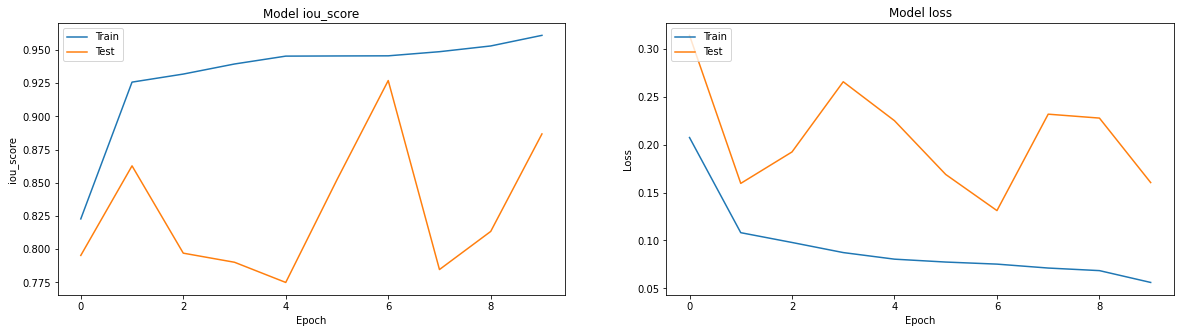

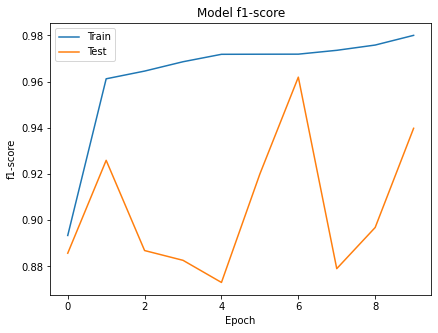

In [69]:
# Plot training & validation iou_score values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



# Plot training & validation f1_score values
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [70]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

In [ ]:
# load best weights
# model.load_weights('best_model.h5') 

In [71]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.16042
mean iou_score: 0.88676
mean f1-score: 0.93978


# FPN + inceptionresnetv2

In [72]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

In [73]:
BACKBONE = 'inceptionresnetv2'
BATCH_SIZE = 8
CLASSES = ['target1']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [74]:
# define network parameters
n_classes = 1 
# f len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' 
# if n_classes == 1 else 'softmax'

#create model
model = sm.FPN(BACKBONE, classes=n_classes, activation=activation)



# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (256, 256, 3), activation=activation)
# I personally would chose (None, None, 3) for the input shape
#

219062272/219055592 [==============================] - 2s 0us/step


In [75]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [78]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/fpn binary/best_modelinceptionresnetv2.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/fpn binary/fpn-inceptionresnetv2.csv', separator=",", append=True)
]

In [79]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
62/62 [==============================] - 199s 3s/step - loss: 0.1724 - iou_score: 0.8692 - f1-score: 0.9261 - val_loss: 0.1207 - val_iou_score: 0.9375 - val_f1-score: 0.9676
Epoch 2/10
62/62 [==============================] - 105s 2s/step - loss: 0.1031 - iou_score: 0.9314 - f1-score: 0.9643 - val_loss: 0.1352 - val_iou_score: 0.9047 - val_f1-score: 0.9499
Epoch 3/10
62/62 [==============================] - 105s 2s/step - loss: 0.0801 - iou_score: 0.9447 - f1-score: 0.9714 - val_loss: 0.1170 - val_iou_score: 0.9404 - val_f1-score: 0.9692
Epoch 4/10
62/62 [==============================] - 105s 2s/step - loss: 0.0683 - iou_score: 0.9550 - f1-score: 0.9769 - val_loss: 0.1204 - val_iou_score: 0.9417 - val_f1-score: 0.9699
Epoch 5/10
62/62 [==============================] - 105s 2s/step - loss: 0.0654 - iou_score: 0.9568 - f1-score: 0.9779 - val_loss: 0.1132 - val_iou_score: 0.9592 - val_f1-score: 0.9790
Epoch 6/10
62/62 [==============================] - 105s 2s/step - loss: 0.

In [80]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.053538
mean iou_score: 0.96929
mean f1-score: 0.98435


In [81]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.11665
mean iou_score: 0.9593
mean f1-score: 0.9791


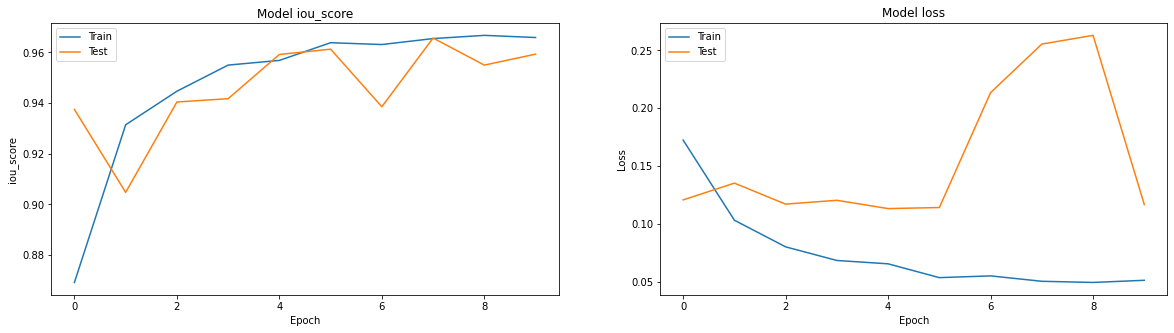

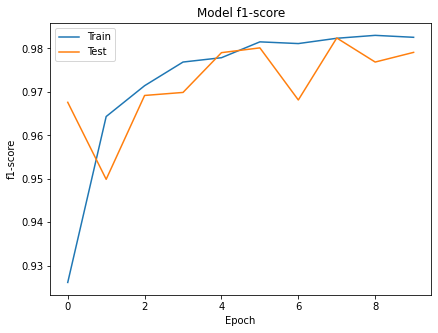

In [82]:
# Plot training & validation iou_score values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



# Plot training & validation f1_score values
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [86]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

In [ ]:
# load best weights
# model.load_weights('best_model.h5') 

In [87]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.11665
mean iou_score: 0.9593
mean f1-score: 0.9791


# FPN + mobilenetv2

In [88]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

In [89]:
BACKBONE = 'mobilenetv2'
BATCH_SIZE = 8
CLASSES = ['target1']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [90]:
# define network parameters
n_classes = 1 
# f len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' 
# if n_classes == 1 else 'softmax'

#create model
model = sm.FPN(BACKBONE, classes=n_classes, activation=activation)



# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (256, 256, 3), activation=activation)
# I personally would chose (None, None, 3) for the input shape
#

/usr/local/lib/python3.7/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 0s 0us/step


In [91]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [92]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/fpn binary/best_modelmobilenetv2.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/fpn binary/fpn-mobilenetv2.csv', separator=",", append=True)
]

In [93]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
62/62 [==============================] - 81s 1s/step - loss: 0.2054 - iou_score: 0.8391 - f1-score: 0.9083 - val_loss: 0.1153 - val_iou_score: 0.9223 - val_f1-score: 0.9595
Epoch 2/10
62/62 [==============================] - 57s 927ms/step - loss: 0.1072 - iou_score: 0.9284 - f1-score: 0.9627 - val_loss: 0.1376 - val_iou_score: 0.8803 - val_f1-score: 0.9362
Epoch 3/10
62/62 [==============================] - 57s 924ms/step - loss: 0.0932 - iou_score: 0.9357 - f1-score: 0.9666 - val_loss: 0.1015 - val_iou_score: 0.9258 - val_f1-score: 0.9614
Epoch 4/10
62/62 [==============================] - 57s 922ms/step - loss: 0.0795 - iou_score: 0.9462 - f1-score: 0.9722 - val_loss: 0.1102 - val_iou_score: 0.8843 - val_f1-score: 0.9382
Epoch 5/10
62/62 [==============================] - 57s 925ms/step - loss: 0.0746 - iou_score: 0.9482 - f1-score: 0.9733 - val_loss: 0.1046 - val_iou_score: 0.9391 - val_f1-score: 0.9685
Epoch 6/10
62/62 [==============================] - 57s 924ms/step -

In [94]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.060875
mean iou_score: 0.95396
mean f1-score: 0.97634


In [95]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.10762
mean iou_score: 0.9408
mean f1-score: 0.96942


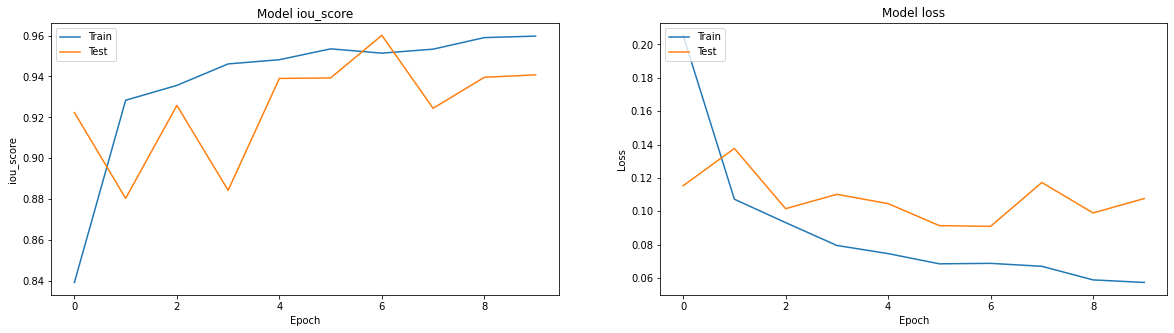

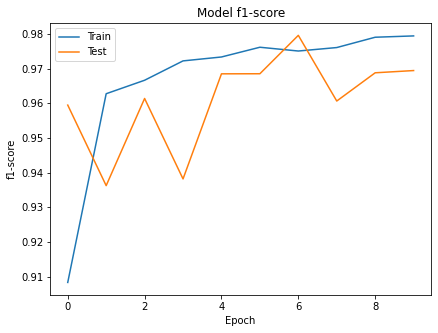

In [96]:
# Plot training & validation iou_score values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



# Plot training & validation f1_score values
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [97]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

In [98]:
# load best weights
# model.load_weights('best_model.h5') 

In [99]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.10762
mean iou_score: 0.9408
mean f1-score: 0.96942


# FPN + densenet121

In [100]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

In [101]:
BACKBONE = 'densenet121'
BATCH_SIZE = 8
CLASSES = ['target1']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [102]:
# define network parameters
n_classes = 1 
# f len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' 
# if n_classes == 1 else 'softmax'

#create model
model = sm.FPN(BACKBONE, classes=n_classes, activation=activation)



# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (256, 256, 3), activation=activation)
# I personally would chose (None, None, 3) for the input shape
#

29089792/29084464 [==============================] - 1s 0us/step


In [103]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [104]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/fpn binary/best_modeldensenet121.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/fpn binary/fpn-densenet121.csv', separator=",", append=True)
]

In [105]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
62/62 [==============================] - 141s 2s/step - loss: 0.2193 - iou_score: 0.8427 - f1-score: 0.9080 - val_loss: 0.1334 - val_iou_score: 0.9408 - val_f1-score: 0.9693
Epoch 2/10
62/62 [==============================] - 80s 1s/step - loss: 0.1022 - iou_score: 0.9400 - f1-score: 0.9689 - val_loss: 0.1672 - val_iou_score: 0.9002 - val_f1-score: 0.9472
Epoch 3/10
62/62 [==============================] - 80s 1s/step - loss: 0.0818 - iou_score: 0.9490 - f1-score: 0.9738 - val_loss: 0.1691 - val_iou_score: 0.8836 - val_f1-score: 0.9381
Epoch 4/10
62/62 [==============================] - 79s 1s/step - loss: 0.0734 - iou_score: 0.9535 - f1-score: 0.9761 - val_loss: 0.1681 - val_iou_score: 0.8729 - val_f1-score: 0.9320
Epoch 5/10
62/62 [==============================] - 79s 1s/step - loss: 0.0678 - iou_score: 0.9558 - f1-score: 0.9773 - val_loss: 0.1249 - val_iou_score: 0.9246 - val_f1-score: 0.9607
Epoch 6/10
62/62 [==============================] - 79s 1s/step - loss: 0.0616 

In [106]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.030546
mean iou_score: 0.9656
mean f1-score: 0.98242


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

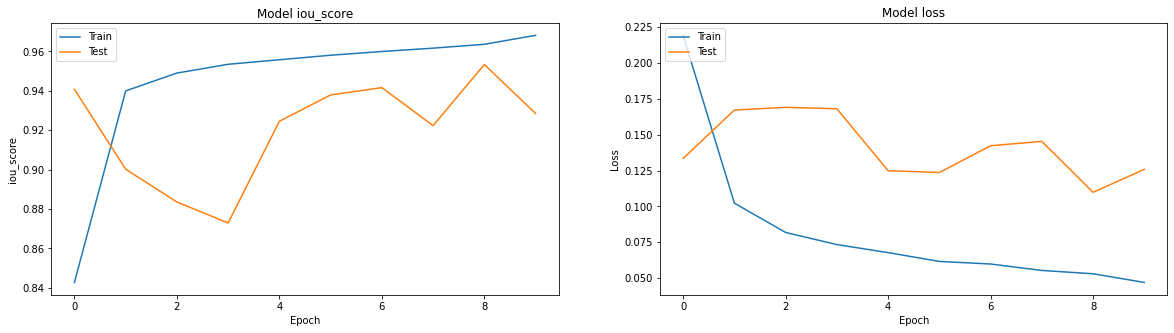

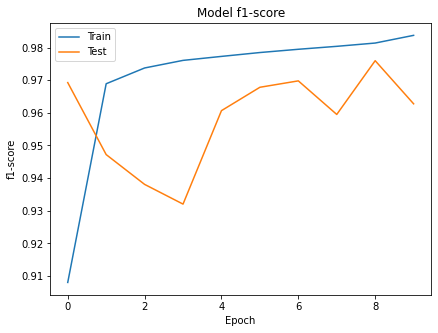

In [108]:
# Plot training & validation iou_score values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



# Plot training & validation f1_score values
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [109]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

In [110]:
# load best weights
# model.load_weights('best_model.h5') 

In [111]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.12581
mean iou_score: 0.92853
mean f1-score: 0.96278


# FPN + seresnet101

In [112]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

In [113]:
BACKBONE = 'seresnet101'
BATCH_SIZE = 8
CLASSES = ['target1']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [114]:
# define network parameters
n_classes = 1 
# f len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' 
# if n_classes == 1 else 'softmax'

#create model
model = sm.FPN(BACKBONE, classes=n_classes, activation=activation)



# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (256, 256, 3), activation=activation)
# I personally would chose (None, None, 3) for the input shape
#

190668800/190663368 [==============================] - 2s 0us/step


In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/fpn binary/best_modelseresnet101.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/fpn binary/fpn-seresnet101.csv', separator=",", append=True)
]

In [124]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
62/62 [==============================] - 115s 2s/step - loss: 0.0605 - iou_score: 0.9560 - f1-score: 0.9774 - val_loss: 0.1531 - val_iou_score: 0.9659 - val_f1-score: 0.9826
Epoch 2/10
62/62 [==============================] - 114s 2s/step - loss: 0.0462 - iou_score: 0.9682 - f1-score: 0.9838 - val_loss: 0.1044 - val_iou_score: 0.9659 - val_f1-score: 0.9826
Epoch 3/10
62/62 [==============================] - 114s 2s/step - loss: 0.0429 - iou_score: 0.9684 - f1-score: 0.9839 - val_loss: 0.1161 - val_iou_score: 0.9659 - val_f1-score: 0.9826
Epoch 4/10
62/62 [==============================] - 114s 2s/step - loss: 0.0427 - iou_score: 0.9680 - f1-score: 0.9837 - val_loss: 0.1107 - val_iou_score: 0.9656 - val_f1-score: 0.9824
Epoch 5/10
62/62 [==============================] - 114s 2s/step - loss: 0.0432 - iou_score: 0.9682 - f1-score: 0.9838 - val_loss: 0.1102 - val_iou_score: 0.9645 - val_f1-score: 0.9818
Epoch 6/10
62/62 [==============================] - 114s 2s/step - loss: 0.

In [125]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.06325
mean iou_score: 0.97303
mean f1-score: 0.98629


In [126]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.10822
mean iou_score: 0.96538
mean f1-score: 0.98227


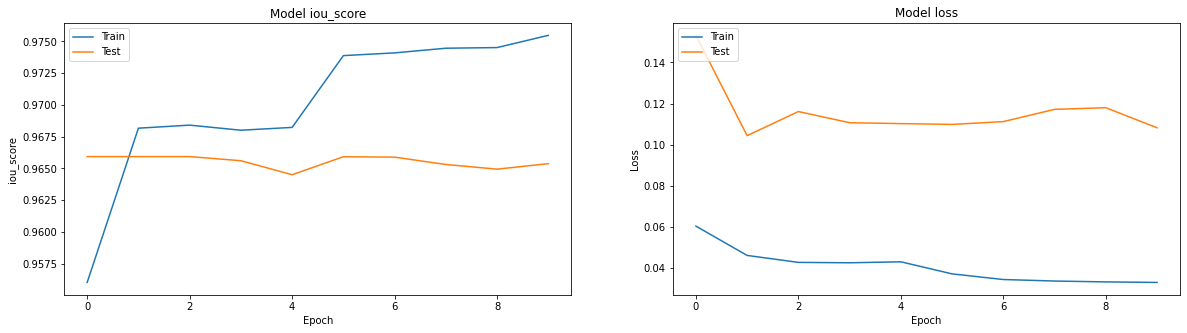

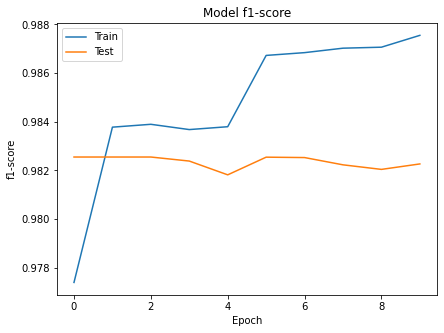

In [127]:
# Plot training & validation iou_score values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



# Plot training & validation f1_score values
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [128]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

In [ ]:
# load best weights
# model.load_weights('best_model.h5') 

In [129]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.10822
mean iou_score: 0.96538
mean f1-score: 0.98227
